In [1]:
import functions as funcs
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

In [2]:
total_df = funcs.get_image_df()
total_df = funcs.train_test_split_df(total_df=total_df)

In [3]:
from ultralytics import YOLO

In [4]:
model = YOLO(model='../Yolo/best.pt')

In [ ]:
model.train()

In [5]:
yolo_folder_path = Path().cwd().parent / "Yolo"
test_images_folder_path = yolo_folder_path/'test'/'images'
image_names = ['A014_18Z_T15092_MID_x40_z0_i01j42.jpg', 'A014_18Z_T15092_MID_x40_z0_i02j06.jpg','A014_18Z_T15092_MID_x40_z0_i09j08.jpg']
test_images = [test_images_folder_path/image_name for image_name in image_names]

In [6]:
results = model.predict(source = test_images)


0: 1024x1024 1 Monocyte, 1: 1024x1024 1 Neutrophil, 2: 1024x1024 1 Neutrophil, 1 Monocyte, 23644.6ms
Speed: 28.3ms preprocess, 7881.5ms inference, 42.9ms postprocess per image at shape (1, 3, 1024, 1024)


In [7]:
from dump import plot_image_file

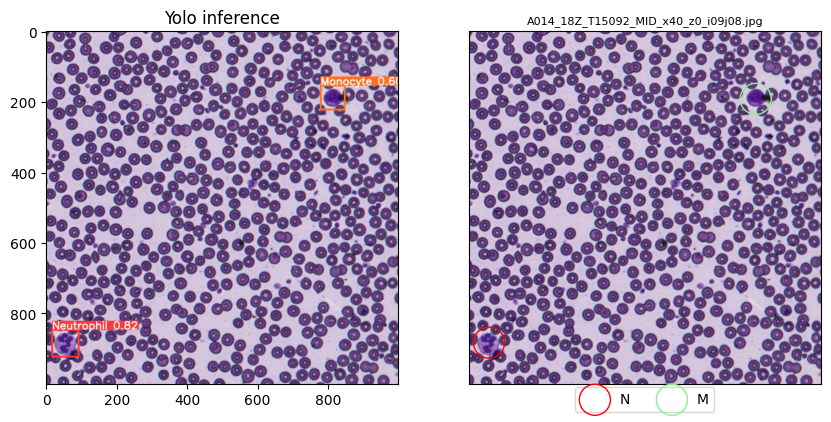

In [14]:
result_arr = results[2].plot()
result_arr = cv2.cvtColor(result_arr, cv2.COLOR_BGRA2RGB)
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plot_image_file(ax=axs[1], image_file_name=image_names[2], total_df=total_df)
axs[0].imshow(result_arr)
axs[0].set_title("Yolo inference")
plt.show()

0 [     17.018      846.76      92.444      922.67]
1 [     778.18      154.13      846.93      222.98]


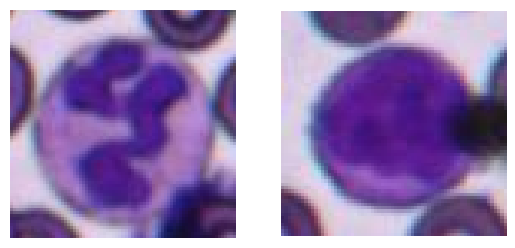

In [32]:
img = funcs.get_image_from_path(file_path=test_images[2])
rois = []
_, ax = plt.subplots(nrows=1, ncols=len(results[2].boxes.xyxy))
for i, result in enumerate(results[2].boxes.xyxy.numpy()):
    print(i, result)
    x_min, y_min, x_max, y_max = result
    roi = img[int(y_min):int(y_max), int(x_min):int(x_max)]
    rois.append(roi)
    ax[i].imshow(roi)
    ax[i].axis('off')
plt.show()

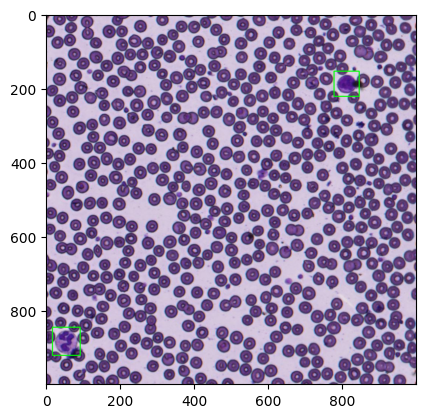

In [30]:
# Find the location of a ROI in an image
whole_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template_gray = cv2.cvtColor(rois[1], cv2.COLOR_BGR2GRAY)
result = cv2.matchTemplate(whole_gray, template_gray, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
h, w = template_gray.shape
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
plt.imshow(img)
plt.show()

In [33]:
from dump import get_binary_image

<Axes: title={'center': 'N19120_2I1_N19120_RT_x40_z0_i01j20.jpg'}>

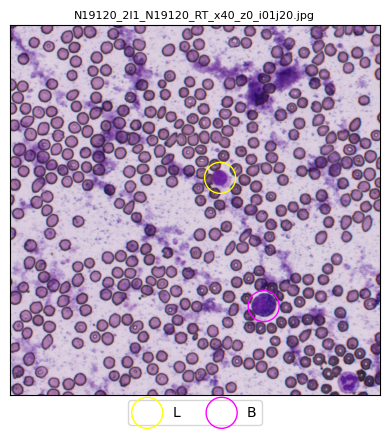

In [55]:
from dump import plot_image_file

_, ax = plt.subplots()
plot_image_file(ax=ax, image_file_name="N19120_2I1_N19120_RT_x40_z0_i01j20.jpg", total_df=total_df)

In [147]:
from result_evaluation import calculate_class_metrics

In [151]:
result_list_file = yolo_folder_path/ "results_list.pickle"
with open(file=result_list_file, mode="rb") as f:
    results_list = pickle.load(f)

In [152]:
len(results_list)

106

In [156]:
class_metrics = calculate_class_metrics(pred_results_list=results_list,
                                        label_folder_path=yolo_folder_path/'test'/'labels')

In [194]:
for class_name, values in class_metrics.items():
    print(class_name, values)

Neutrophil {'true_positive': 79, 'false_positive': 18, 'false_negative': 0}
Lymphocyte {'true_positive': 19, 'false_positive': 14, 'false_negative': 0}
Monocyte {'true_positive': 11, 'false_positive': 19, 'false_negative': 0}
Eosinophil {'true_positive': 2, 'false_positive': 5, 'false_negative': 0}
Basophil {'true_positive': 0, 'false_positive': 0, 'false_negative': 0}


In [191]:
def get_precision_recall_f1(class_metrics:dict) -> tuple[float, float, float]:
    """ Returns the precision, recall and F1 score for a class metrics dict 
    """
    true_positives = [class_metrics[class_name]['true_positive'] for class_name in class_metrics]
    false_positives = [class_metrics[class_name]['false_positive'] for class_name in class_metrics]
    false_negatives = [class_metrics[class_name]['false_negative'] for class_name in class_metrics]
    try:
        overall_precision = round(number=sum(true_positives) / (sum(true_positives) + sum(false_positives)), ndigits= 4)
    except ZeroDivisionError:
        overall_precision = 0
    try:
        overall_recall = round(number = sum(true_positives) / (sum(true_positives) + sum(false_negatives)), ndigits= 4)
    except ZeroDivisionError:
        overall_recall = 0
    try:
        overall_f1_score = round(number=2 * (overall_precision * overall_recall) / (overall_precision + overall_recall), ndigits= 4)
    except ZeroDivisionError:
        overall_f1_score = 0
    return overall_precision, overall_recall, overall_f1_score   

In [192]:
precision, recall, f1 = get_precision_recall_f1(class_metrics=class_metrics)
precision, recall, f1

(0.6647, 1.0, 0.7986)